## Librerías:

In [40]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

# Visualizar una matriz de confusión para una etiqueta específica
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Parámetros y funciones:

In [41]:
def plot_confusion_matrix(conf_matrix, class_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Matriz de Confusión para la clase: {class_name}')
    plt.show()

In [42]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (str): Ruta del archivo CSV con nombres de archivo y etiquetas.
            img_dir (str): Ruta a la carpeta de imágenes.
            transform (callable, optional): Transformaciones a aplicar a las imágenes.
        """
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtener el ID del archivo desde el CSV
        img_id = self.data.iloc[idx, 0]  # Primera columna (ID)
        extensions = ["", ".jpg", ".png", ".tif"]
        img_path = None

        # Buscar la imagen con diferentes extensiones
        for ext in extensions:
            temp_path = os.path.join(self.img_dir, str(img_id) + ext)
            if os.path.exists(temp_path):
                img_path = temp_path
                break

        if img_path is None:
            raise FileNotFoundError(
                f"No se encontró la imagen para el ID '{img_id}' en {self.img_dir} con extensiones {extensions}."
            )

        # Cargar la imagen
        image = Image.open(img_path).convert("RGB")  # Convertir a RGB
        if self.transform:
            image = self.transform(image)

        # Leer etiquetas multi-label
        labels = torch.tensor(self.data.iloc[idx, 1:].values.astype(float))
        return image, labels


In [43]:
class AdaptiveAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(AdaptiveAttention, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, src, mask=None):
        attn_output, _ = self.self_attn(src, src, src, key_padding_mask=mask)
        src = src + self.dropout(attn_output)
        src = self.norm(src)
        return src

class AdaptiveTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(AdaptiveTransformerEncoderLayer, self).__init__()
        self.adaptive_attention = AdaptiveAttention(d_model, nhead, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src2 = self.adaptive_attention(src, mask=src_mask)
        src = src + self.dropout(src2)
        src = self.norm1(src)

        src2 = self.feed_forward(src)
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

class AdaptiveAttentionClassifier(nn.Module):
    def __init__(self, image_feature_dim, num_classes):
        super(AdaptiveAttentionClassifier, self).__init__()
        self.image_embed = nn.Linear(image_feature_dim, 512)
        self.transformer_encoder = nn.ModuleList([
            AdaptiveTransformerEncoderLayer(d_model=512, nhead=8) for _ in range(6)
        ])
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, image_features):
        # Proyección de características
        image_embeddings = self.image_embed(image_features)

        # Pasar por las capas del Transformer
        for layer in self.transformer_encoder:
            image_embeddings = layer(image_embeddings.unsqueeze(1)).squeeze(1)

        # Clasificador final
        output = self.mlp(image_embeddings)
        return output


In [44]:
# Obtener el directorio actual
current_directory = os.getcwd()
data_directory = os.path.join(current_directory[:-3], 'data')
images_directory = os.path.join(data_directory, 'images')

num_epochs = 20
subset = [os.path.splitext(filename)[0] for filename in os.listdir(images_directory)]
print(len(subset))
#subset = ['(0001)aria_d_26', '(0001)aria_d_27', '(0003)aria_d_29','(0004)aria_d_28', '(0007)aria_d_28', '(0018)aria_d_26', '(0024)aria_d_30', '(0026)aria_d_27', '(0031)aria_c_37',
#          '1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36']

90


## Carga de datos:

### Selección de subset para pruebas:

In [46]:
train_1 = pd.read_csv(f'{data_directory}/train_data_1.csv')
test_1 = pd.read_csv(f'{data_directory}/test_data_1.csv')

train_1 = train_1[train_1['ID'].isin(subset)]
test_1 = test_1[test_1['ID'].isin(subset)]

train_1.to_csv(f'{data_directory}/train_data_2.csv', encoding = 'utf-8', index=False)
train_1.to_csv(f'{data_directory}/test_data_2.csv', encoding = 'utf-8', index=False)

In [47]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset y DataLoader
train_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/train_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
test_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/test_data_2.csv", img_dir=f"{images_directory}/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Instanciar modelo:

In [48]:
# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
import torchvision.models as models
resnet.fc = nn.Identity()  # Remover la capa final
resnet = resnet.to(device)

model = AdaptiveAttentionClassifier(image_feature_dim=2048, num_classes=train_dataset[0][1].size(0))
model = model.to(device)

# Optimizador y función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Entrenamiento:

In [ ]:
# Entrenamiento

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            image_features = resnet(images).flatten(start_dim=1)
            outputs = model(image_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Imprimir métricas
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/20, Train Loss: 0.5624, Val Loss: 0.2783
Epoch 2/20, Train Loss: 0.2593, Val Loss: 0.1969
Epoch 3/20, Train Loss: 0.1954, Val Loss: 0.1840
Epoch 4/20, Train Loss: 0.1851, Val Loss: 0.1849
Epoch 5/20, Train Loss: 0.1811, Val Loss: 0.1805
Epoch 6/20, Train Loss: 0.1783, Val Loss: 0.1740
Epoch 7/20, Train Loss: 0.1731, Val Loss: 0.1710
Epoch 8/20, Train Loss: 0.1726, Val Loss: 0.1707
Epoch 9/20, Train Loss: 0.1722, Val Loss: 0.1707
Epoch 10/20, Train Loss: 0.1701, Val Loss: 0.1700
Epoch 11/20, Train Loss: 0.1713, Val Loss: 0.1703
Epoch 12/20, Train Loss: 0.1741, Val Loss: 0.1711
Epoch 13/20, Train Loss: 0.1717, Val Loss: 0.1703
Epoch 14/20, Train Loss: 0.1706, Val Loss: 0.1709
Epoch 15/20, Train Loss: 0.1706, Val Loss: 0.1692
Epoch 16/20, Train Loss: 0.1712, Val Loss: 0.1695
Epoch 17/20, Train Loss: 0.1721, Val Loss: 0.1714
Epoch 18/20, Train Loss: 0.1723, Val Loss: 0.1699
Epoch 19/20, Train Loss: 0.1678, Val Loss: 0.1693
Epoch 20/20, Train Loss: 0.1704, Val Loss: 0.1703


## Inferencia y métricas:

Reporte de clasificación (por etiqueta):
              precision    recall  f1-score   support

          DR       0.00      0.00      0.00        13
      NORMAL       0.00      0.00      0.00         5
          MH       0.00      0.00      0.00         3
         ODC       0.00      0.00      0.00         5
        TSLN       0.00      0.00      0.00         1
        ARMD       0.00      0.00      0.00         2
          DN       0.00      0.00      0.00         2
         MYA       0.00      0.00      0.00         2
        BRVO       0.00      0.00      0.00         0
         ODP       0.00      0.00      0.00         0
        CRVO       0.00      0.00      0.00         0
         CNV       0.00      0.00      0.00         0
          RS       0.00      0.00      0.00         0
         ODE       0.00      0.00      0.00         0
          LS       0.00      0.00      0.00         1
         CSR       0.00      0.00      0.00         0
         HTR       0.00      0.00      0

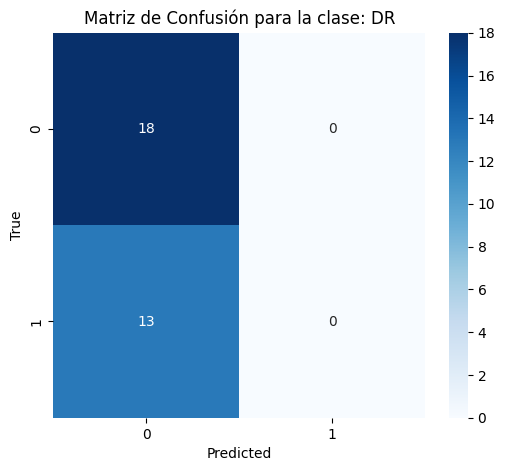

In [ ]:
# Coloca el modelo en modo evaluación
model.eval()

# Listas para almacenar etiquetas reales y predicciones
all_labels = list()
all_preds = list()

# Realizar inferencia
with torch.no_grad():  # No calculamos gradientes
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Extraer características con ResNet y pasar por el modelo
        image_features = resnet(images).flatten(start_dim=1)
        outputs = model(image_features)

        # Aplicar sigmoid para obtener probabilidades
        probs = torch.sigmoid(outputs)

        # Convertir probabilidades en predicciones binarias (umbral = 0.5)
        preds = (probs > 0.5).int()

        # Guardar etiquetas reales y predicciones
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Convertir listas a arreglos
all_labels = np.vstack(all_labels)  # Etiquetas reales
all_preds = np.vstack(all_preds)    # Predicciones

# Calcular matriz de confusión para cada etiqueta
confusion_matrices = multilabel_confusion_matrix(all_labels, all_preds)

# Imprimir métricas de clasificación
print("Reporte de clasificación (por etiqueta):")
print(classification_report(all_labels, all_preds, target_names=test_dataset.data.columns[1:], zero_division=0))

# Ejemplo: Visualizar la matriz de confusión para la primera etiqueta
class_name = test_dataset.data.columns[1]
plot_confusion_matrix(confusion_matrices[0], class_name)
